In [15]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

import wordcloud
import matplotlib.pyplot as plt
import gc

import lightgbm as lgb
%matplotlib inline

Load train và test data

In [2]:
# Load data
train_df = pd.read_csv("./data/train.csv")
test_df = pd.read_csv("./data/test.csv")

In [3]:
train_df.head()

,id,comment,label
0,train_000000,Dung dc sp tot cam on \nshop Đóng gói sản phẩm...,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng...,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đ...,1


In [4]:
test_df.head()

,id,comment
0,test_000000,Chưa dùng thử nên chưa biết
1,test_000001,Không đáng tiềnVì ngay đợt sale nên mới mua n...
2,test_000002,Cám ơn shop. Đóng gói sản phẩm rất đẹp và chắc...
3,test_000003,Vải đẹp.phom oki luôn.quá ưng
4,test_000004,Chuẩn hàng đóng gói đẹp


Kiểm tra xem data có bao nhiêu bình luận là NULL

Thay thế tất cả bình luận là NULL bằng none

In [5]:
train_comments = train_df['comment'].fillna("none").values
test_comments = test_df['comment'].fillna("none").values

y_train = train_df['label'].values

Wordcloud dùng để hiển thị những từ xuất hiện nhiều trong data

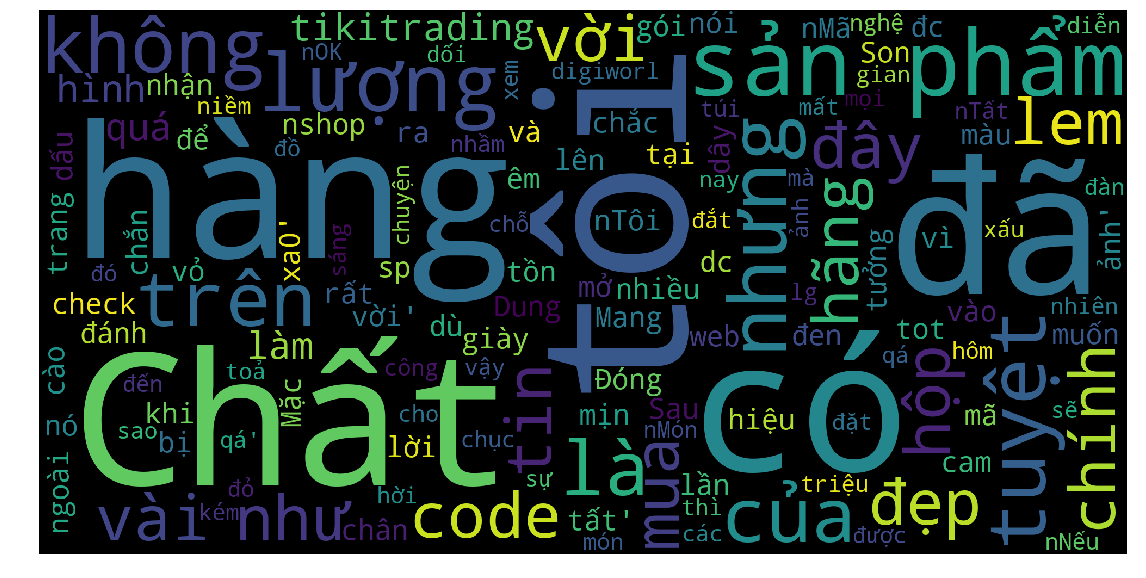

In [6]:
# Wordcloud of training set
cloud = np.array(train_comments).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(
    max_words=200,background_color ="black",
    width=2000,height=1000,mode="RGB"
).generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

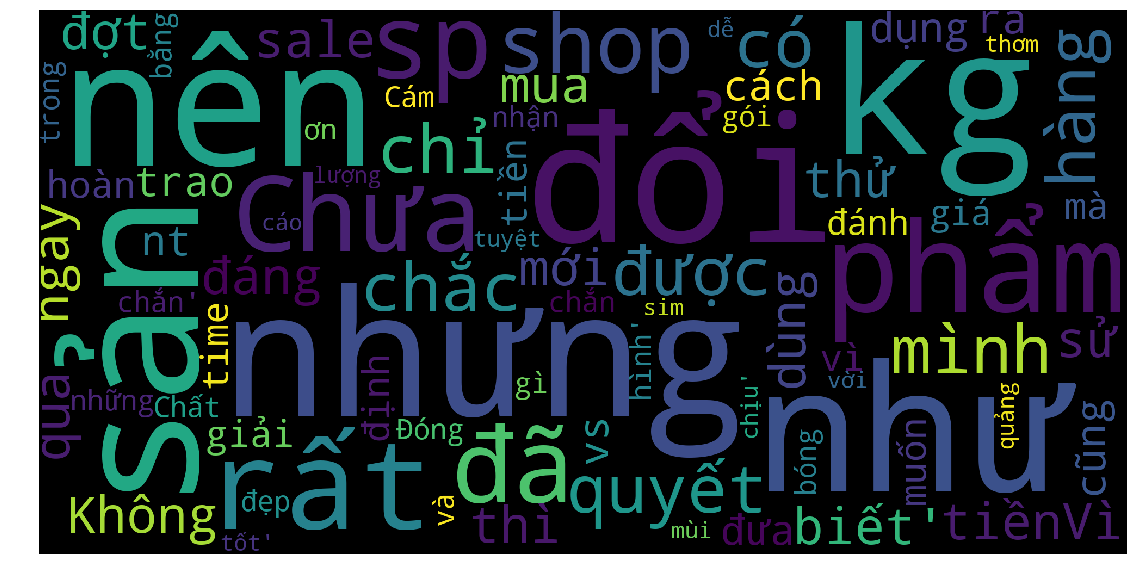

In [7]:
# Wordcloud of test set
cloud = np.array(test_comments).flatten()
plt.figure(figsize=(20,10))
word_cloud = wordcloud.WordCloud(
    max_words=100,background_color ="black",
    width=2000,height=1000,mode="RGB"
).generate(str(cloud))
plt.axis("off")
plt.imshow(word_cloud)

Tạo feature TFIDF đơn giản

In [8]:
tfidf = TfidfVectorizer(
    min_df=5, 
    max_df= 0.8, 
    max_features=10000,
    sublinear_tf=True
)

In [9]:
X_train = tfidf.fit_transform(train_comments)
X_test = tfidf.transform(test_comments)

In [10]:
X_train.shape, X_test.shape, y_train.shape

((16087, 2679), (10981, 2679), (16087,))

LightGBM không có metric là F1 Score, mình tạo hàm để theo dõi trong việc training

In [11]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

In [16]:
print("Starting LightGBM. Train shape: {}, test shape: {}".format(X_train.shape, X_test.shape))

# Cross validation model
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=69)

# Create arrays and dataframes to store results
oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

# k-fold
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train, y_train)):
    print("Fold %s" % (n_fold))
    train_x, train_y = X_train[train_idx], y_train[train_idx]
    valid_x, valid_y = X_train[valid_idx], y_train[valid_idx]

    # set data structure
    lgb_train = lgb.Dataset(train_x,
                            label=train_y,
                            free_raw_data=False)
    lgb_test = lgb.Dataset(valid_x,
                           label=valid_y,
                           free_raw_data=False)

    params = {
        'objective' :'binary',
        'learning_rate' : 0.01,
        'num_leaves' : 76,
        'feature_fraction': 0.64, 
        'bagging_fraction': 0.8, 
        'bagging_freq':1,
        'boosting_type' : 'gbdt',
    }

    reg = lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        valid_names=['train', 'valid'],
        num_boost_round=10000,
        verbose_eval=100,
        early_stopping_rounds=100,
        feval=lgb_f1_score
    )

    oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
    sub_preds += reg.predict(X_test, num_iteration=reg.best_iteration) / folds.n_splits

    del reg, train_x, train_y, valid_x, valid_y
    gc.collect()

Starting LightGBM. Train shape: (16087, 2679), test shape: (10981, 2679)
Fold 0
Training until validation scores don't improve for 100 rounds.


/home/ngxbac/anaconda3/envs/general/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


[100]	train's binary_logloss: 0.389876	train's f1: 0.876861	valid's binary_logloss: 0.417043	valid's f1: 0.846379
[200]	train's binary_logloss: 0.289428	train's f1: 0.889505	valid's binary_logloss: 0.336951	valid's f1: 0.852205
[300]	train's binary_logloss: 0.238221	train's f1: 0.902742	valid's binary_logloss: 0.304551	valid's f1: 0.854924
Early stopping, best iteration is:
[251]	train's binary_logloss: 0.259854	train's f1: 0.896293	valid's binary_logloss: 0.3171	valid's f1: 0.85583
Fold 1
Training until validation scores don't improve for 100 rounds.
[100]	train's binary_logloss: 0.392269	train's f1: 0.876435	valid's binary_logloss: 0.416002	valid's f1: 0.840807
[200]	train's binary_logloss: 0.290251	train's f1: 0.89016	valid's binary_logloss: 0.331658	valid's f1: 0.85859
[300]	train's binary_logloss: 0.238826	train's f1: 0.901803	valid's binary_logloss: 0.297181	valid's f1: 0.863636
[400]	train's binary_logloss: 0.20542	train's f1: 0.91449	valid's binary_logloss: 0.281482	valid's f1:

In [20]:
threshold = 0.5
preds = (sub_preds > threshold).astype(np.uint8)

In [22]:
submission = pd.read_csv("./data/SA_demo/sample_submission.csv")
submission['label'] = preds

In [23]:
submission.head()

,id,label
0,test_000000,0
1,test_000001,1
2,test_000002,0
3,test_000003,0
4,test_000004,0


In [24]:
submission.to_csv("lgbm_tfidf.csv", index=False)